In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Root Finding

In [4]:
from scipy import integrate

## Q1: 

# FFTs

In [5]:
from scipy.integrate import ode

## Q2: FFT of chaotic pendulum

Last time we looked at ODEs and the chaotic pendulum, and were interested in writing a method to integrate the pendulum in time.

Here we want to examine its behavior in frequency space.  The code below will integrate the chaotic pendulum using a fixed dt, which makes it suitable for taking the FFT.

In [12]:
def rhs(t, Y, q, omega_d, b):
    """ damped driven pendulum system derivatives.  Here, Y = (theta, omega) are
        the solution variables. """
    f = np.zeros_like(Y)
        
    f[0] = Y[1]
    f[1] = -q*Y[1] - np.sin(Y[0]) + b*np.cos(omega_d*t)

    return f

def restrict_theta(theta):
    """ convert theta to be restricted to lie between -pi and pi"""
    tnew = theta + np.pi
    tnew += -2.0*np.pi*np.floor(tnew/(2.0*np.pi))
    tnew -= np.pi
    return tnew

def int_pendulum(theta0, q, omega_d, b, tend, dt):
    """ integrate the pendulum with a fixed timestep, dt"""
    r = ode(rhs)
    r.set_integrator("dopri5", nsteps=150000, first_step=dt, max_step=dt, dfactor=1.0)

    sol = []
    r.set_solout(lambda t, y: sol.append([t, *y]))

    t0 = 0.0
    omega0 = 0.0
    r.set_initial_value((theta0, omega0), t0)

    r.set_f_params(q, omega_d, b)

    r.integrate(tend)
    return np.array(sol)



The call below will give an undamped pendulum.  For a small amplitude, since we have $L = g$ in our pendulum, the period is simply $T = 2\pi$, and the frequency is $\nu_k = 1/(2\pi)$.  We plot things in terms of angular frequency, $\omega_k = 2\pi \nu_k$, so all the power will be at $\omega_k = 1$.

In [49]:
s = int_pendulum(np.radians(10), 0.0, 0.6666, 0.0, 200.0, 0.1)

Your task is to complete the power spectrum routine below to calculate the FFT of theta

In [50]:
def power_spectrum(t, theta0):
    """ return the power spectrum of theta.  For the frequency
        component, return it in terms of omega """

    theta = restrict_theta(theta0)

    N = len(t)    
    F = (2.0/N)*np.fft.rfft(theta)

    k = np.fft.rfftfreq(N)
    kfreq = 2.0*np.pi*k*N/max(t)

    return kfreq, F

In [51]:
omega, F = power_spectrum(s[:,0], s[:,1])

(0.0, 2.0)

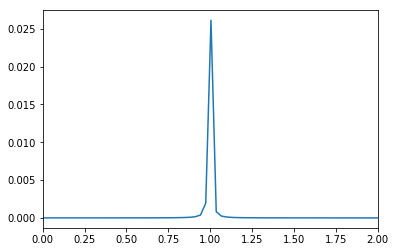

In [52]:
plt.plot(omega, np.abs(F)**2)
plt.xlim(0.0, 2.0)

In [47]:
s = int_pendulum(np.radians(60), 0.5, 0.6666, 1.6, 200.0, 0.1)

(0.0, 2.0)

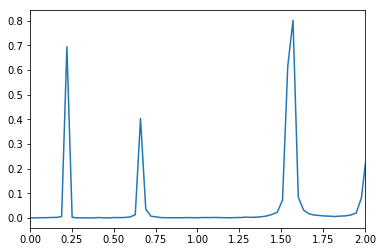

In [48]:
omega, F = power_spectrum(s[:,0], s[:,1])
plt.plot(omega, np.abs(F)**2)
plt.xlim(0.0, 2.0)

# Fitting

## Q3: Let's find the errors on our fit

We looked at fits, but not what the errors are on the fit.  Look at `scipy.optimize.curve_fit()`.  This is a simplified wrapper on the least squares fitting.  It can return the convariance matrix, the diagonals of which can give the error of the fit for the parameters.  

Make up some data that models a non-linear function (by introducing some random noise) and perform a fit and find the errors on the parameters.

In [ ]:
s = int_pendulum(np.radians(60), 0.5, 0.6666, 1.5, 200.0)